Wizualizacja odczytów poziomu pyłu na określonych obszarach

Wczytano i wyczyszczono dane. 
Ilość rekordów przed czyszczeniem: 452280
Ilość rekordów po czyszczeniu: 438262
Wyczyszczono: 14018
    
Wyniki na podstawie 10809 rekordów
Parametr: PM10
Wizualizacja wyników pomiarów podzielonych na progi jakości powietrza


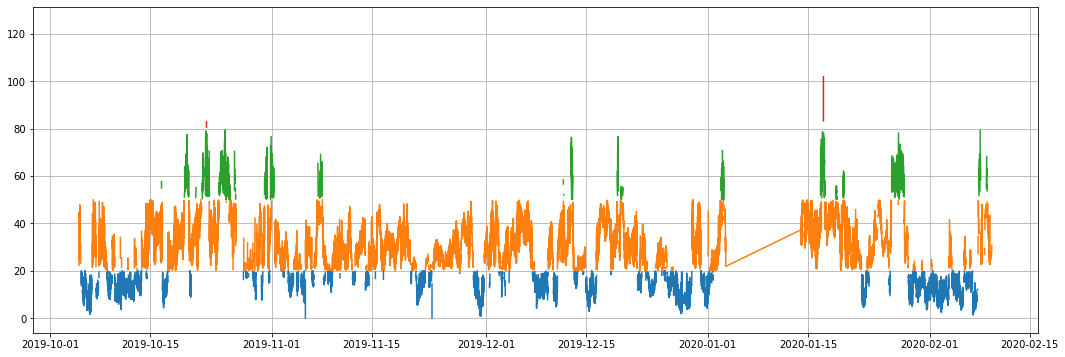

Wykres przedstawiający procentowy rozkład odczytów podzielonych na stan powietrza


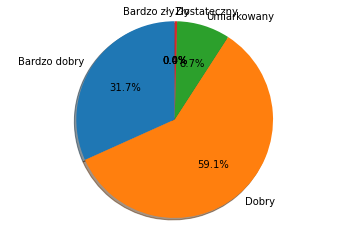

Wyniki na podstawie 27251 rekordów
Parametr: PM10
Wizualizacja wyników pomiarów podzielonych na progi jakości powietrza


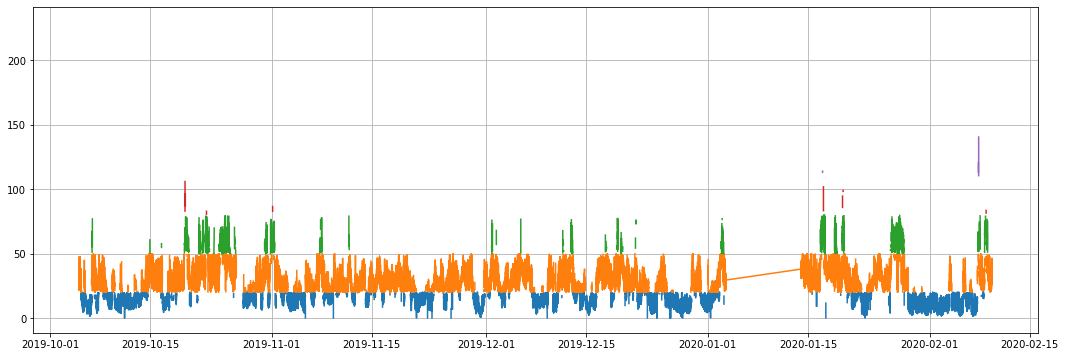

Wykres przedstawiający procentowy rozkład odczytów podzielonych na stan powietrza


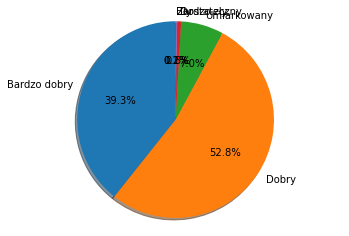

In [1]:
import pandas as pd
import math
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

#Klasy symbolizujące Lokalizacje i relacje pomiędzy nimi    
class Wojewodztwo:
    #Musi być końcówka - KIE
    def __init__(self, Wojewodztwo):
        self.Name = Wojewodztwo


class Powiat:
    #końcówka - KI lub miasto takie same jak powiat
    def __init__(self, Powiat, Wojewodztwo):
        #sprawdź czy ki i czy takie same miasta
        self.Name = Powiat
        self.Wojewodztwo = Wojewodztwo #jako opbiekt klasy

class Miasto:
    def __init__(self, SzerGeo, DlugGeo, Miasto, Powiat):
        self.Name = Miasto
        self.SzerGeo = SzerGeo
        self.DlugGeo = DlugGeo
        self.Powiat = Powiat #jako obiekt klasy 
#Klasa symbolizująca 1 pomiar czyli 1 rekord
class Measurement:
    def __init__(self, Czas, Parametr, Wartosc, Miasto):
        self.Czas = Czas
        self.Parametr = Parametr
        self.Wartosc = Wartosc
        self.Miasto = Miasto

#plik klasa pliku wejściowego
class ExcelFile:
    def __init__(self):
        #właściwość przechowująca zaimportowany plik XLSX
        self.SourceFile = pd.read_excel (r'C:\Users\slawo\Desktop\Pobrane\Zadanie1Smog.xlsx')      
        #właściwość przechowująca listę(lista) rekordów(Record) z danymi z pliku XLS
        self.Data = self.SourceFile.values.tolist() 
        self.CountRecordsBeforeCleaning = len(self.Data)
        #Tutaj nie wyrzucamy duplikatów, aby sprawdzić poprawność współrzędnych geograficznych
        self.DictionaryMiasto = self.SourceFile[["SzerGeo", "DlugGeo","Miasto"]]
        #Słownik wartości z wojewodztw (jako lista)
        self.DictionaryPowiat = self.SourceFile[["Miasto","Powiat"]].drop_duplicates().values.tolist()
        self.DictionaryWojewodztwo = self.SourceFile["Wojewodztwo"].drop_duplicates().values.tolist()
        self.DictionaryParametr = ("PM10", "PM2.5")
        self.__ClearMiasto()
        self.__ClearPowiat()
        self.__ClearWojewodztwo()
        self.__CreateRecordObjects()
        
    
    # __ - powoduje, że metoda jest prywatna
    #metoda prywatna konwertująca rekordy z DataFrame(self.SourceFile) na obiekty Record
    def __ConvertToObjects(self):
        #Każdy obiekt z listy(list) konwertujemy na obiekr Record
        for record in self.ObjectData:
            record = Record(record)
    
    def __ClearMiasto(self):
        #konwerujemy wartości na int, dzięki czemu zniwelujemy błędy zmiennoprzecinkowe
        self.DictionaryMiasto = self.DictionaryMiasto.copy()
        self.DictionaryMiasto.loc[:, ["SzerGeo", "DlugGeo"]] = self.DictionaryMiasto[["SzerGeo", "DlugGeo"]].astype(int)
        #self.DictionaryMiasto = self.DictionaryMiasto[["SzerGeo", "DlugGeo","Miasto"]].value_counts().to_frame()
        #self.DistionaryMiasto.sort(key=self.__ReturnCell("Miasto"))
        #Dopiero teraz wyrzucamy duplikaty i tworzymy listę
        self.DictionaryMiasto = self.DictionaryMiasto.sort_values(by=['Miasto']).drop_duplicates().values.tolist()
        #lista indeksów do usunięcia
        DeleteIndexs = []
        #sprawdzamy czy miasta się nie powtarzają, margines błędu ustawiłem na 2
        Count = 0
        CountNext = 1
        #maxymalny index, pomniejszamy o 2, bo ostatniego elementu nie porównujemy (a lista od 0), bo jest ostatni 
        #Zabezpeczamy się przed błędym wyjścia poza zakres listy
        MaxCount = len(self.DictionaryMiasto) - 1
        for Miasto in self.DictionaryMiasto:
            #porównanie czy aktualne miasto jest takie samo jak następne
            if Miasto[2] == self.DictionaryMiasto[CountNext][2]:
                #jeśli tak, to obliczamy różnicę za pomocą wartości bezwzględnej
                if math.fabs(Miasto[0] - self.DictionaryMiasto[CountNext][0]) < 3:
                    if math.fabs(Miasto[1] - self.DictionaryMiasto[CountNext][1]) < 3:
                        #jeśli różnica jest mniejsza niż 3, to oznaczamy  rekord do usunięcia, służy nam to temu, 
                        #aby skompletować słownik miast i wykryć anomalie, które wyrzucimy lub poprawnie przyporządkujemy
                        DeleteIndexs.append(Count)
            Count += 1
            #powrót porównania do 1 elementu, aby nie wyjść poza zakres listy
            if CountNext < MaxCount:
                CountNext += 1
            else:
                CountNext = 0
        #Usuwamy duplikaty o małych różnicach, od tyłu, żeby nie zmieniły się indexy
        #sorted zwraca listę, sort jedynie ją "pokazuje", my potrzebujemy zapisanej listy w zmiennej
        DeleteIndexs = sorted(DeleteIndexs, reverse=True)
        for Delete in DeleteIndexs:
            self.DictionaryMiasto.pop(Delete)
        #Sprawdzamy, czy w słowniku są duplikaty, wykorzystująć metodę count(elemnty),
        #która zlicza ilość elementów. Jeśli jakiegoś elementu będzie więcej niż jeden,
        #Duplicates zmieni się na true
        Duplicates = False
        for Miasto in self.DictionaryMiasto:
            if self.DictionaryMiasto.count(Miasto[2]) > 1:
                Duplicates = True
                
        if Duplicates:
            print("W miastach pozostały duplikaty")
            #Tu powinna być funkcja/instrukcja wyrzycająca duplikaty według liczebności,
            #ale, że nie ma duplikatów, pozwoliłem sobię to pominąć, bo nie ma czego czyścić...
            
    def __ClearPowiat(self):
        DeleteIndexs = []
        Count = 0
        #Rozpoczynamy sprawdzanie słownika powiatów
        for Powiat in self.DictionaryPowiat:
            #Niektóre miasta mają prawa powiatu, więc są poprawne, logiczne wtedy,
            #,ze miasto i powiat to tak naprawdę to samo i elementy muszą być identyczne
            #print(Powiat)
            if Powiat[0] != Powiat[1]:
                #Jesli nie są, to sprawdzamy budowę nazwy powiatu, która kończy się na "KI", 
                #wyjątkiem są miasta na prawach powiatu
                if Powiat[1][-2:] != "ki":
                    DeleteIndexs.append(Count)
            Count += 1
        DeleteIndexs = sorted(DeleteIndexs, reverse=True)
        for Delete in DeleteIndexs:
            self.DictionaryPowiat.pop(Delete)   
        

        
        
    def __ClearWojewodztwo(self):
        DeleteIndexs = []
        Count = 0
        #Rozpoczynamy sprawdzanie słownika powiatów
        for Wojewodztwo in self.DictionaryWojewodztwo:
            if Wojewodztwo[-3:] != "KIE":
                DeleteIndexs.append(Count)
            Count += 1
        DeleteIndexs = sorted(DeleteIndexs, reverse=True)
        for Delete in DeleteIndexs:
            self.DictionaryPowiat.pop(Delete)   
        #print(self.DictionaryWojewodztwo)
        
        
    def __CreateRecordObjects(self):
        #Help
        #Data = record[0]
        #Godzina = record[1]
        #Parametr = record[2]
        #Wartosc = record[3]
        #SzerGeo = record[4]
        #DlugGeo = record[5]
        #Miasto = record[6]
        #Powiat = record[7]
        #Wojewodztwo = record[8]
        
        TmpObjectData = []
        for Record in self.Data:
            #Wojewodztwo - sprawdzamy czy jest na liście poprawnych
            if Record[8] in self.DictionaryWojewodztwo:
                TmpWojewodztwo = Wojewodztwo(Record[8])
                #Miasto i Powiat - sprawdzamy czy para miasto-powiat jest poprawna
                if [Record[6], Record[7]] in self.DictionaryPowiat:
                    #Powiat
                    TmpPowiat = Powiat(Record[7], TmpWojewodztwo)
                    #Miasto
                    TmpMiasto = Miasto(Record[4], Record[5], Record[6], TmpPowiat)
                    #Parametr
                    if Record[2] in self.DictionaryParametr:
                        TmpParametr = Record[2]
                        #Wartość
                        if Record[3] >= 0:
                            TmpWartosc = Record[3]
                            #Czas, konwersja czasu(dzień i godzina) na obiekt datetime
                            if Record[1] >= 0 and Record[1] <= 23:
                                try:
                                    TmpTime = Record[0] + timedelta(hours=Record[1])
                                    TmpMeasurement = Measurement(TmpTime, TmpParametr, TmpWartosc, TmpMiasto)
                                    TmpObjectData.append(TmpMeasurement)
                                except:
                                    pass

        #zmieniamy listę list na listę obiektów
        self.Data = TmpObjectData


def PrintChart(Records):
    #przyjmujemy, że rekordy będą zawsze w jednej ze skali
    print(f'Wyniki na podstawie {len(Records)} rekordów')
    print(f'Parametr: {Records[0].Parametr}')
    Scale = {
    "Legenda": ("Bardzo dobry", "Dobry", "Umiarkowany", "Dostateczny", "Zły", "Bardzo zły"),
    "PM10": (20,50,80,110,150),
    "PM2.5": (13, 35, 55, 75, 110)
    }
    Records = sorted(Records, key=lambda Record: Record.Czas)
    X = []
    Y = YList = []
    for Record in Records:
        X.append(Record.Czas)
        Y.append(Record.Wartosc)
    X = np.array(X)
    Y = np.array(Y)

    ScaleOnChart = Scale[Records[0].Parametr]
    
    BardzoDobry = np.ma.masked_where(Y > ScaleOnChart[0], Y)
    Dobry = np.ma.masked_where((Y < ScaleOnChart[0]) | (Y > ScaleOnChart[1]), Y)
    Umiarkowany = np.ma.masked_where((Y < ScaleOnChart[1]) | (Y > ScaleOnChart[2]), Y)
    Dostateczny = np.ma.masked_where((Y < ScaleOnChart[2]) | (Y > ScaleOnChart[3]), Y)
    Zły = np.ma.masked_where((Y < ScaleOnChart[3]) | (Y > ScaleOnChart[4]), Y)
    BardzoZły = np.ma.masked_where(Y < ScaleOnChart[4], Y)

    fig, ax = plt.subplots(figsize=(18,6))
    ax.grid()
    ax.plot(X, BardzoDobry, X, Dobry, X, Umiarkowany, X, Dostateczny, X, Zły, X, BardzoZły)
    print("Wizualizacja wyników pomiarów podzielonych na progi jakości powietrza")
    plt.show()
    
    print("Wykres przedstawiający procentowy rozkład odczytów podzielonych na stan powietrza")
    labels = "Bardzo dobry", "Dobry", "Umiarkowany", "Dostateczny", "Zły", "Bardzo zły"
    CountAll = len(YList)
    L1 = (len([1 for i in YList if i < ScaleOnChart[0]]) / CountAll) * 100
    L2 = (np.count_nonzero(((Y > ScaleOnChart[0]) & (Y <= ScaleOnChart[1]))) / CountAll) * 100
    L3 = (np.count_nonzero(((Y > ScaleOnChart[1]) & (Y <= ScaleOnChart[2]))) / CountAll) * 100
    L4 = (np.count_nonzero(((Y > ScaleOnChart[2]) & (Y <= ScaleOnChart[3]))) / CountAll) * 100
    L5 = (np.count_nonzero(((Y > ScaleOnChart[3]) & (Y <= ScaleOnChart[4]))) / CountAll) * 100
    L6 = (len([1 for i in YList if i > ScaleOnChart[4]]) / CountAll) * 100
    sizes = [L1, L2, L3, L4, L5, L6]
    explode = (0, 0, 0, 0, 0, 0) 

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.show()
    
            

def main():
    Data = ExcelFile()
    print(f'''
Wczytano i wyczyszczono dane. 
Ilość rekordów przed czyszczeniem: {Data.CountRecordsBeforeCleaning}
Ilość rekordów po czyszczeniu: {len(Data.Data)}
Wyczyszczono: {Data.CountRecordsBeforeCleaning - len(Data.Data)}
    ''')
    PM10Warszawa = list(filter(lambda Record: Record.Parametr == "PM10" and Record.Miasto.Name == "Warszawa", Data.Data))
    PrintChart(PM10Warszawa)
    
    PM10Mazowieckie = list(filter(lambda Record: Record.Parametr == "PM10" and Record.Miasto.Powiat.Wojewodztwo.Name == "MAZOWIECKIE", Data.Data))
    PrintChart(PM10Mazowieckie)
    
        
if __name__ == "__main__":
    print('Wizualizacja odczytów poziomu pyłu na określonych obszarach')
    main()